# **Classification**

In [1]:
import pandas as pd
import numpy as np

bbbp_df=pd.read_csv("../datasets/bbbp.csv")
bbbp_df=bbbp_df.loc[~bbbp_df['smiles'].str.contains('.', regex=False)]
targets=bbbp_df["p_np"].values
smiles=bbbp_df["smiles"].values
print(smiles.shape, targets.shape)

bbbp_df

(1934,) (1934,)


,smiles,p_np
1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,1
2,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,1
3,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,1
4,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...,1
5,CCN1CCN(C(=O)N[C@@H](C(=O)N[C@H]2[C@H]3SCC(=C(...,1
...,...,...
2034,C1=C(Cl)C(=C(C2=C1NC(=O)C(N2)=O)[N+](=O)[O-])Cl,1
2035,[C@H]3([N]2C1=C(C(=NC=N1)N)N=C2)[C@@H]([C@@H](...,1
2036,[O+]1=N[N](C=C1[N-]C(NC2=CC=CC=C2)=O)C(CC3=CC=...,1
2037,C1=C(OC)C(=CC2=C1C(=[N+](C(=C2CC)C)[NH-])C3=CC...,1


# **Regression data**

In [2]:
import pandas as pd
import numpy as np

delaney_df=pd.read_csv("../datasets/delaney.csv")
delaney_df=delaney_df.loc[~delaney_df['smiles'].str.contains('.', regex=False)]
targets=delaney_df["logSolubility"].values
smiles=delaney_df["smiles"].values
print(smiles.shape, targets.shape)

delaney_df

(1128,) (1128,)


,smiles,logSolubility
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.770
1,Cc1occc1C(=O)Nc2ccccc2,-3.300
2,CC(C)=CCCC(C)=CC(=O),-2.060
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.870
4,c1ccsc1,-1.330
...,...,...
1123,FC(F)(F)C(Cl)Br,-1.710
1124,CNC(=O)ON=C(SC)C(=O)N(C)C,0.106
1125,CCSCCSP(=S)(OC)OC,-3.091
1126,CCC(C)C,-3.180


# **Load model**

In [3]:
import sys
sys.path.insert(0, '../')

import molecule_vae

grammar_weights = "../weights/GrammarVAE_L128.hdf5"
grammar_model = molecule_vae.GrammarModel(grammar_weights, latent_rep_size=128)

two_tower_grammar_weights = "../weights/Two_tower_GrammarVAE_L128.hdf5"
two_tower_grammar_model = molecule_vae.GrammarModel(two_tower_grammar_weights, latent_rep_size=128, two_tower=True)

character_weights = "../weights/CharVAE_L128.hdf5"
character_model = molecule_vae.CharacterModel(character_weights, latent_rep_size=128)

two_tower_character_weights = "../weights/Two_tower_CharVAE_L128.hdf5"
two_tower_character_model = molecule_vae.CharacterModel(two_tower_character_weights, latent_rep_size=128, two_tower=True)

Using TensorFlow backend.
C:\Users\jonat\Anaconda3\envs\multiview_chemvae\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\jonat\Anaconda3\envs\multiview_chemvae\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\jonat\Anaconda3\envs\multiview_chemvae\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\jo

1e-04
1e-04
1e-04
1e-04


# **Encoding datasets**

In [4]:
import numpy as np
from tqdm import tqdm
from descriptastorus.descriptors import rdNormalizedDescriptors
from rdkit.Chem import MolToSmiles, MolFromSmiles, SanitizeMol

generator = rdNormalizedDescriptors.RDKit2DNormalized()

def rdkit_2d_normalized_features(smiles: str):
    results = generator.process(smiles)
    processed, features = results[0], results[1:]
    if processed is None:
       print("Unable to process smiles %s", smiles)
    return features

def rdkit_features(smiles_list):
    features=[]
    for compound in tqdm(smiles_list):
        features.append(rdkit_2d_normalized_features(compound))

    features=np.expand_dims(features, axis=2)
    return features

def encode_smiles(model, smiles, features=None):
    latent_rep_dict={}
    latent_rep_list = []
    smiles_list=[]
    targets_list=[]

    for s in tqdm(range(len(smiles))):
        try:
            mol = MolFromSmiles(smiles[s])
            SanitizeMol(mol)
            smi = MolToSmiles(mol, isomericSmiles=True)
            if features is not None:
                z = model.encode([smi], np.array(features[s]).reshape(-1,200,1))
            else:
                z = model.encode([smi])
            latent_rep_dict[smi]=z.flatten()
            latent_rep_list.append(z.flatten())
            smiles_list.append(smi)
            targets_list.append(targets[s])

        except:
            # print(smiles[s])
            continue

    return smiles_list, latent_rep_dict, latent_rep_list, targets_list

In [5]:
# RDKit features
features = rdkit_features(smiles)
features.shape

# Grammar model
two_tower_grammar_smiles_list, latent_dict, two_tower_grammar_latent_rep_list, two_tower_grammar_targets_list = encode_smiles(two_tower_grammar_model, smiles, features)
grammar_smiles_list, latent_dict, grammar_latent_rep_list, grammar_targets_list = encode_smiles(grammar_model, smiles )

# Character model
two_tower_character_smiles_list, latent_dict, two_tower_character_latent_rep_list, two_tower_character_targets_list = encode_smiles(two_tower_character_model, smiles, features)
character_smiles_list, latent_dict, character_latent_rep_list, character_targets_list = encode_smiles(character_model, smiles)

  0%|          | 0/1128 [00:00<?, ?it/s]


100%|██████████| 1128/1128 [00:04<00:00, 245.07it/s]


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

def create_model(hidden_size=1024, classification=True, input_size=56, output_size=1, activation='sigmoid', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()]):
    model = Sequential()
    model.add(Input(shape=(input_size)))
    model.add(Dense(units=hidden_size, activation='relu', ))    
    model.add(Dropout(0.5))        
    model.add(Dense(units=output_size, activation=activation))

    model.compile(loss=loss, optimizer='adam', metrics=metrics)
    return model

early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    mode='min'
)

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import interp
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
plt.rcParams.update(plt.rcParamsDefault)
from tensorflow.keras import backend as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

def rmse(y_pred, y_true):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def get_multilabel_ROC_score(X,y,latent_rep_size, output_size, folds=10):
    kfold = KFold(n_splits=folds, shuffle=True, random_state=0)
    print(X.shape, y.shape)

    aucs = []
    for train, test in tqdm(kfold.split(X, y), total=folds):
        plt.hist(X[test].flatten(), bins=100)
        plt.show()
        model=create_model(input_size=latent_rep_size, output_size=output_size)
        model.fit(X[train], y[train], epochs=250, batch_size=256, validation_split=0.1,  verbose=1, callbacks = [early_stop])
        preds=model.predict(X[test], batch_size=256)
        print(preds.shape)
        # fig=sns.heatmap(confusion_matrix([y[0] for y in y[test]], [round(x[0], 0) for x in preds]), annot=True, cmap='Blues', square=True, vmin=0, vmax=1)
       

        plt.scatter(y[test], preds)
        plt.show()
        # fig=sns.heatmap(confusion_matrix([y[1] for y in y[test]], [round(x[1], 0) for x in preds]), annot=True, cmap='Blues', square=True, vmin=0, vmax=1)
        # plt.show()
        try:
            score=roc_auc_score(y[test], preds)
            print(score)
            aucs.append(score)
        except:
            continue
    print(np.average(aucs), np.std(aucs))

def get_regression_loss(X,y,latent_rep_size, loss_metric, folds=10):
    kfold = KFold(n_splits=folds, shuffle=True, random_state=0)
    losses = []
    for train, test in tqdm(kfold.split(X, y), total=folds):
        model=create_model(input_size=latent_rep_size, activation="linear", loss=loss_metric, metrics=[])

        model.fit(X[train], y[train], epochs=250, batch_size=256, validation_split=0.1,  verbose=0, callbacks = [early_stop])
        loss=model.evaluate(X[test], y[test])
        # print(loss)
        losses.append(loss)
    print(np.average(losses), np.std(losses))

def get_average_ROC_curve(X, y, latent_rep_size, folds=10): 
    kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=0)

    interp_tprs = []
    tprs = []
    fprs = []
    aucs = []
    base_fpr = np.linspace(0, 1, 101)
    print("Training model...")
    
    for train, test in tqdm(kfold.split(X, y), total=folds):
        model=create_model(input_size=latent_rep_size)

        model.fit(X[train], y[train], epochs=250, batch_size=256, validation_split=0.1,  verbose=0, callbacks = [early_stop])

        preds=model.predict(X[test], batch_size=256)
        fpr, tpr, _ = roc_curve(y[test], preds)
        tprs.append(tpr)
        fprs.append(fpr)

        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        interp_tprs.append(tpr)

    interp_tprs = np.array(interp_tprs)
    mean_tprs = interp_tprs.mean(axis=0)
    std = interp_tprs.std(axis=0)

    mean_auc = auc(base_fpr, mean_tprs)
    std_auc = np.std(aucs)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std

    return fprs, tprs, base_fpr, mean_tprs, mean_auc, std_auc, tprs_lower, tprs_upper
 
def plot_average_ROC_curves(roc_curves, dataset_name, model_names, folds=10,):

    plt.figure(figsize=(8, 6))
    # colors = ['darkblue', 'blue', 'darkorange', 'orange', 'darkgreen', 'green']
    colors = ['blue', 'red', ]

    for i in range(len(roc_curves)):
        fprs, tprs, base_fpr, mean_tprs, mean_auc, std_auc, tprs_lower, tprs_upper = roc_curves[i]
        color=colors[i]
        model_name=model_names[i]
        # for j in range(len(tprs)):
        #     plt.plot(fprs[j], tprs[j], color, alpha=0.15, lw = 1)       
        plt.plot(base_fpr, mean_tprs, color, alpha = 0.9, label=model_name+ r' Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),)
        plt.fill_between(base_fpr, tprs_lower, tprs_upper, color = color, alpha = 0.1)
   
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc="lower right")
    plt.title('{} ROC curve using stratified {}-fold cross-validation '.format(dataset_name, folds))
    plt.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'Random chance', alpha= 0.8)
    #plt.axes().set_aspect('equal', 'datalim')
    plt.show()



In [12]:
get_regression_loss(np.array(two_tower_grammar_latent_rep_list), np.array(grammar_targets_list), latent_rep_size=128, loss_metric=rmse)
get_regression_loss(np.array(grammar_latent_rep_list), np.array(grammar_targets_list), latent_rep_size=128, loss_metric=rmse)

get_regression_loss(np.array(two_tower_character_latent_rep_list), np.array(character_targets_list), latent_rep_size=128, loss_metric="mae")
get_regression_loss(np.array(character_latent_rep_list), np.array(character_targets_list), latent_rep_size=128, loss_metric="mae")

  0%|          | 0/10 [00:00<?, ?it/s]

113/113 [==============================] - 0s 44us/sample - loss: 0.6442


 10%|█         | 1/10 [00:04<00:43,  4.79s/it]

113/113 [==============================] - 0s 49us/sample - loss: 0.7071


 20%|██        | 2/10 [00:09<00:37,  4.74s/it]

113/113 [==============================] - 0s 43us/sample - loss: 0.6267


 30%|███       | 3/10 [00:14<00:33,  4.79s/it]

113/113 [==============================] - 0s 49us/sample - loss: 0.5882


 40%|████      | 4/10 [00:19<00:28,  4.75s/it]

113/113 [==============================] - 0s 54us/sample - loss: 0.6050


 50%|█████     | 5/10 [00:23<00:23,  4.75s/it]

113/113 [==============================] - 0s 111us/sample - loss: 0.6118


 60%|██████    | 6/10 [00:28<00:19,  4.88s/it]

112/112 [==============================] - 0s 38us/sample - loss: 0.5620


 70%|███████   | 7/10 [00:33<00:14,  4.86s/it]

112/112 [==============================] - 0s 45us/sample - loss: 0.5203


 80%|████████  | 8/10 [00:38<00:09,  4.77s/it]

112/112 [==============================] - 0s 45us/sample - loss: 0.6183


 90%|█████████ | 9/10 [00:43<00:04,  4.83s/it]

112/112 [==============================] - 0s 44us/sample - loss: 0.6285


  0%|          | 0/10 [00:00<?, ?it/s]

0.6111904909765976 0.047039606894233234
113/113 [==============================] - 0s 44us/sample - loss: 1.3742


 10%|█         | 1/10 [00:04<00:40,  4.45s/it]

113/113 [==============================] - 0s 44us/sample - loss: 1.3403


 20%|██        | 2/10 [00:09<00:39,  4.94s/it]

113/113 [==============================] - 0s 46us/sample - loss: 1.2808


 30%|███       | 3/10 [00:15<00:36,  5.18s/it]

113/113 [==============================] - 0s 44us/sample - loss: 1.1314


 40%|████      | 4/10 [00:20<00:31,  5.22s/it]

113/113 [==============================] - 0s 44us/sample - loss: 1.3530


 50%|█████     | 5/10 [00:26<00:27,  5.48s/it]

113/113 [==============================] - 0s 44us/sample - loss: 1.3754


 60%|██████    | 6/10 [00:32<00:22,  5.61s/it]

112/112 [==============================] - 0s 49us/sample - loss: 1.1464


 70%|███████   | 7/10 [00:38<00:17,  5.85s/it]

112/112 [==============================] - 0s 124us/sample - loss: 1.3855


 80%|████████  | 8/10 [00:42<00:10,  5.24s/it]

112/112 [==============================] - 0s 150us/sample - loss: 1.2730


 90%|█████████ | 9/10 [00:50<00:06,  6.06s/it]

112/112 [==============================] - 0s 86us/sample - loss: 1.3976


  0%|          | 0/10 [00:00<?, ?it/s]

1.3057532138679784 0.09232781523826225
113/113 [==============================] - 0s 44us/sample - loss: 0.5269


 10%|█         | 1/10 [00:05<00:53,  5.92s/it]

113/113 [==============================] - 0s 58us/sample - loss: 0.5766


 20%|██        | 2/10 [00:11<00:45,  5.70s/it]

113/113 [==============================] - 0s 53us/sample - loss: 0.5367


 30%|███       | 3/10 [00:17<00:41,  5.86s/it]

113/113 [==============================] - 0s 62us/sample - loss: 0.4772


 40%|████      | 4/10 [00:23<00:35,  5.90s/it]

113/113 [==============================] - 0s 79us/sample - loss: 0.4847


 50%|█████     | 5/10 [00:30<00:30,  6.17s/it]

113/113 [==============================] - 0s 82us/sample - loss: 0.5699


 60%|██████    | 6/10 [00:37<00:26,  6.55s/it]

113/113 [==============================] - 0s 71us/sample - loss: 0.4400


 70%|███████   | 7/10 [00:45<00:20,  6.96s/it]

113/113 [==============================] - 0s 73us/sample - loss: 0.4266


 80%|████████  | 8/10 [00:50<00:13,  6.52s/it]

112/112 [==============================] - 0s 45us/sample - loss: 0.4572


 90%|█████████ | 9/10 [00:57<00:06,  6.50s/it]

112/112 [==============================] - 0s 158us/sample - loss: 0.5270


  0%|          | 0/10 [00:00<?, ?it/s]

0.5022550591325338 0.05008453091915836
113/113 [==============================] - 0s 144us/sample - loss: 1.1843


 10%|█         | 1/10 [00:10<01:31, 10.14s/it]

113/113 [==============================] - 0s 67us/sample - loss: 1.1040


 20%|██        | 2/10 [00:18<01:12,  9.01s/it]

113/113 [==============================] - 0s 75us/sample - loss: 1.0954


 30%|███       | 3/10 [00:27<01:02,  8.97s/it]

113/113 [==============================] - 0s 93us/sample - loss: 1.0238


 40%|████      | 4/10 [00:33<00:48,  8.08s/it]

113/113 [==============================] - 0s 81us/sample - loss: 1.1270


 50%|█████     | 5/10 [00:41<00:39,  7.86s/it]

113/113 [==============================] - 0s 98us/sample - loss: 1.0799


 60%|██████    | 6/10 [00:49<00:32,  8.08s/it]

113/113 [==============================] - 0s 86us/sample - loss: 1.0607


 70%|███████   | 7/10 [00:58<00:24,  8.23s/it]

113/113 [==============================] - 0s 90us/sample - loss: 1.0308


 80%|████████  | 8/10 [01:06<00:16,  8.29s/it]

112/112 [==============================] - 0s 110us/sample - loss: 1.0867


 90%|█████████ | 9/10 [01:16<00:08,  8.56s/it]

112/112 [==============================] - 0s 89us/sample - loss: 1.0033


100%|██████████| 10/10 [01:23<00:00,  8.36s/it]

1.0795962130902843 0.050769287236354155


In [ ]:
get_multilabel_ROC_score(np.array(two_tower_grammar_latent_rep_list), np.array(grammar_targets_list), latent_rep_size=128, output_size=2)
get_multilabel_ROC_score(np.array(grammar_latent_rep_list), np.array(grammar_targets_list), latent_rep_size=128, output_size=2)

# get_multilabel_ROC_score(np.array(two_tower_character_latent_rep_list), np.array(character_targets_list), latent_rep_size=128, output_size=2)
# get_multilabel_ROC_score(np.array(character_latent_rep_list), np.array(character_targets_list), latent_rep_size=128, output_size=2)

  0%|          | 0/10 [00:00<?, ?it/s]

Training model...


  0%|          | 0/10 [00:00<?, ?it/s]

Training model...


100%|██████████| 10/10 [01:37<00:00,  9.71s/it]


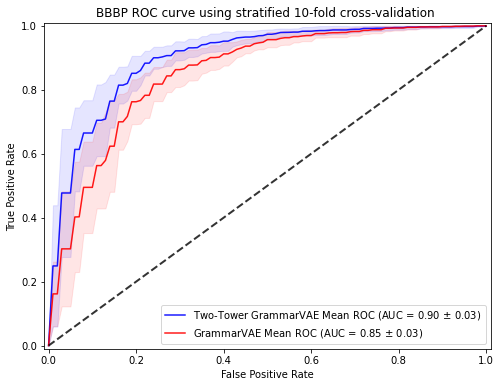

  0%|          | 0/10 [00:00<?, ?it/s]

Training model...


  0%|          | 0/10 [00:00<?, ?it/s]

Training model...


100%|██████████| 10/10 [01:40<00:00, 10.03s/it]


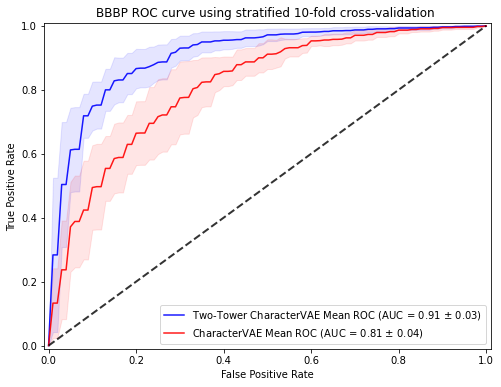

In [19]:
roc_curves=[]
roc_curves.append(get_average_ROC_curve(np.array(two_tower_grammar_latent_rep_list), np.array(grammar_targets_list), latent_rep_size=128))
roc_curves.append(get_average_ROC_curve(np.array(grammar_latent_rep_list), np.array(grammar_targets_list), latent_rep_size=128))
plot_average_ROC_curves(roc_curves, "BBBP", ["Two-Tower GrammarVAE", "GrammarVAE"])

roc_curves=[]
roc_curves.append(get_average_ROC_curve(np.array(two_tower_character_latent_rep_list), np.array(character_targets_list), latent_rep_size=128))
roc_curves.append(get_average_ROC_curve(np.array(character_latent_rep_list), np.array(character_targets_list), latent_rep_size=128))
plot_average_ROC_curves(roc_curves, "BBBP", ["Two-Tower CharacterVAE", "CharacterVAE"])